In [26]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from thefuzz import fuzz, process
from scipy import stats
import statsmodels.api as sm
from scipy.stats import pearsonr

In [2]:
# Load Data

#Cases
dengue = pd.read_csv('National_extract_V1_2_2.csv')

# Urban population numbers
# Skip first 16 rows, use row 17 as header, then skip until row 30
urban_pop= pd.read_excel(
    'WUP2018-F19-Urban_Population_Annual.xls',
    header=16,
    skiprows=list(range(17, 29))
)

<h1><center> Cases Data </center></h1>

In [3]:
dengue.columns

Index(['adm_0_name', 'adm_1_name', 'adm_2_name', 'full_name', 'ISO_A0',
       'FAO_GAUL_code', 'RNE_iso_code', 'IBGE_code', 'calendar_start_date',
       'calendar_end_date', 'Year', 'dengue_total',
       'case_definition_standardised', 'S_res', 'T_res', 'UUID'],
      dtype='object')

In [4]:
# Time Range

min(dengue['Year']), max(dengue['Year'])

(1924, 2023)

In [5]:
# number of data points for cases
len(dengue)

31032

In [6]:
# number of unique countries
len(dengue["full_name"].unique())

102

In [7]:
# Filter to include only data from 2000 to 2022
dengue_sub = dengue[(dengue["Year"] >= 2000) & (dengue["Year"] < 2023)]

In [8]:
# Number of data points after filtering
len(dengue_sub)

28971

In [9]:
# Pecentage of data points after filtering
len(dengue_sub) /len(dengue)

0.933584686774942

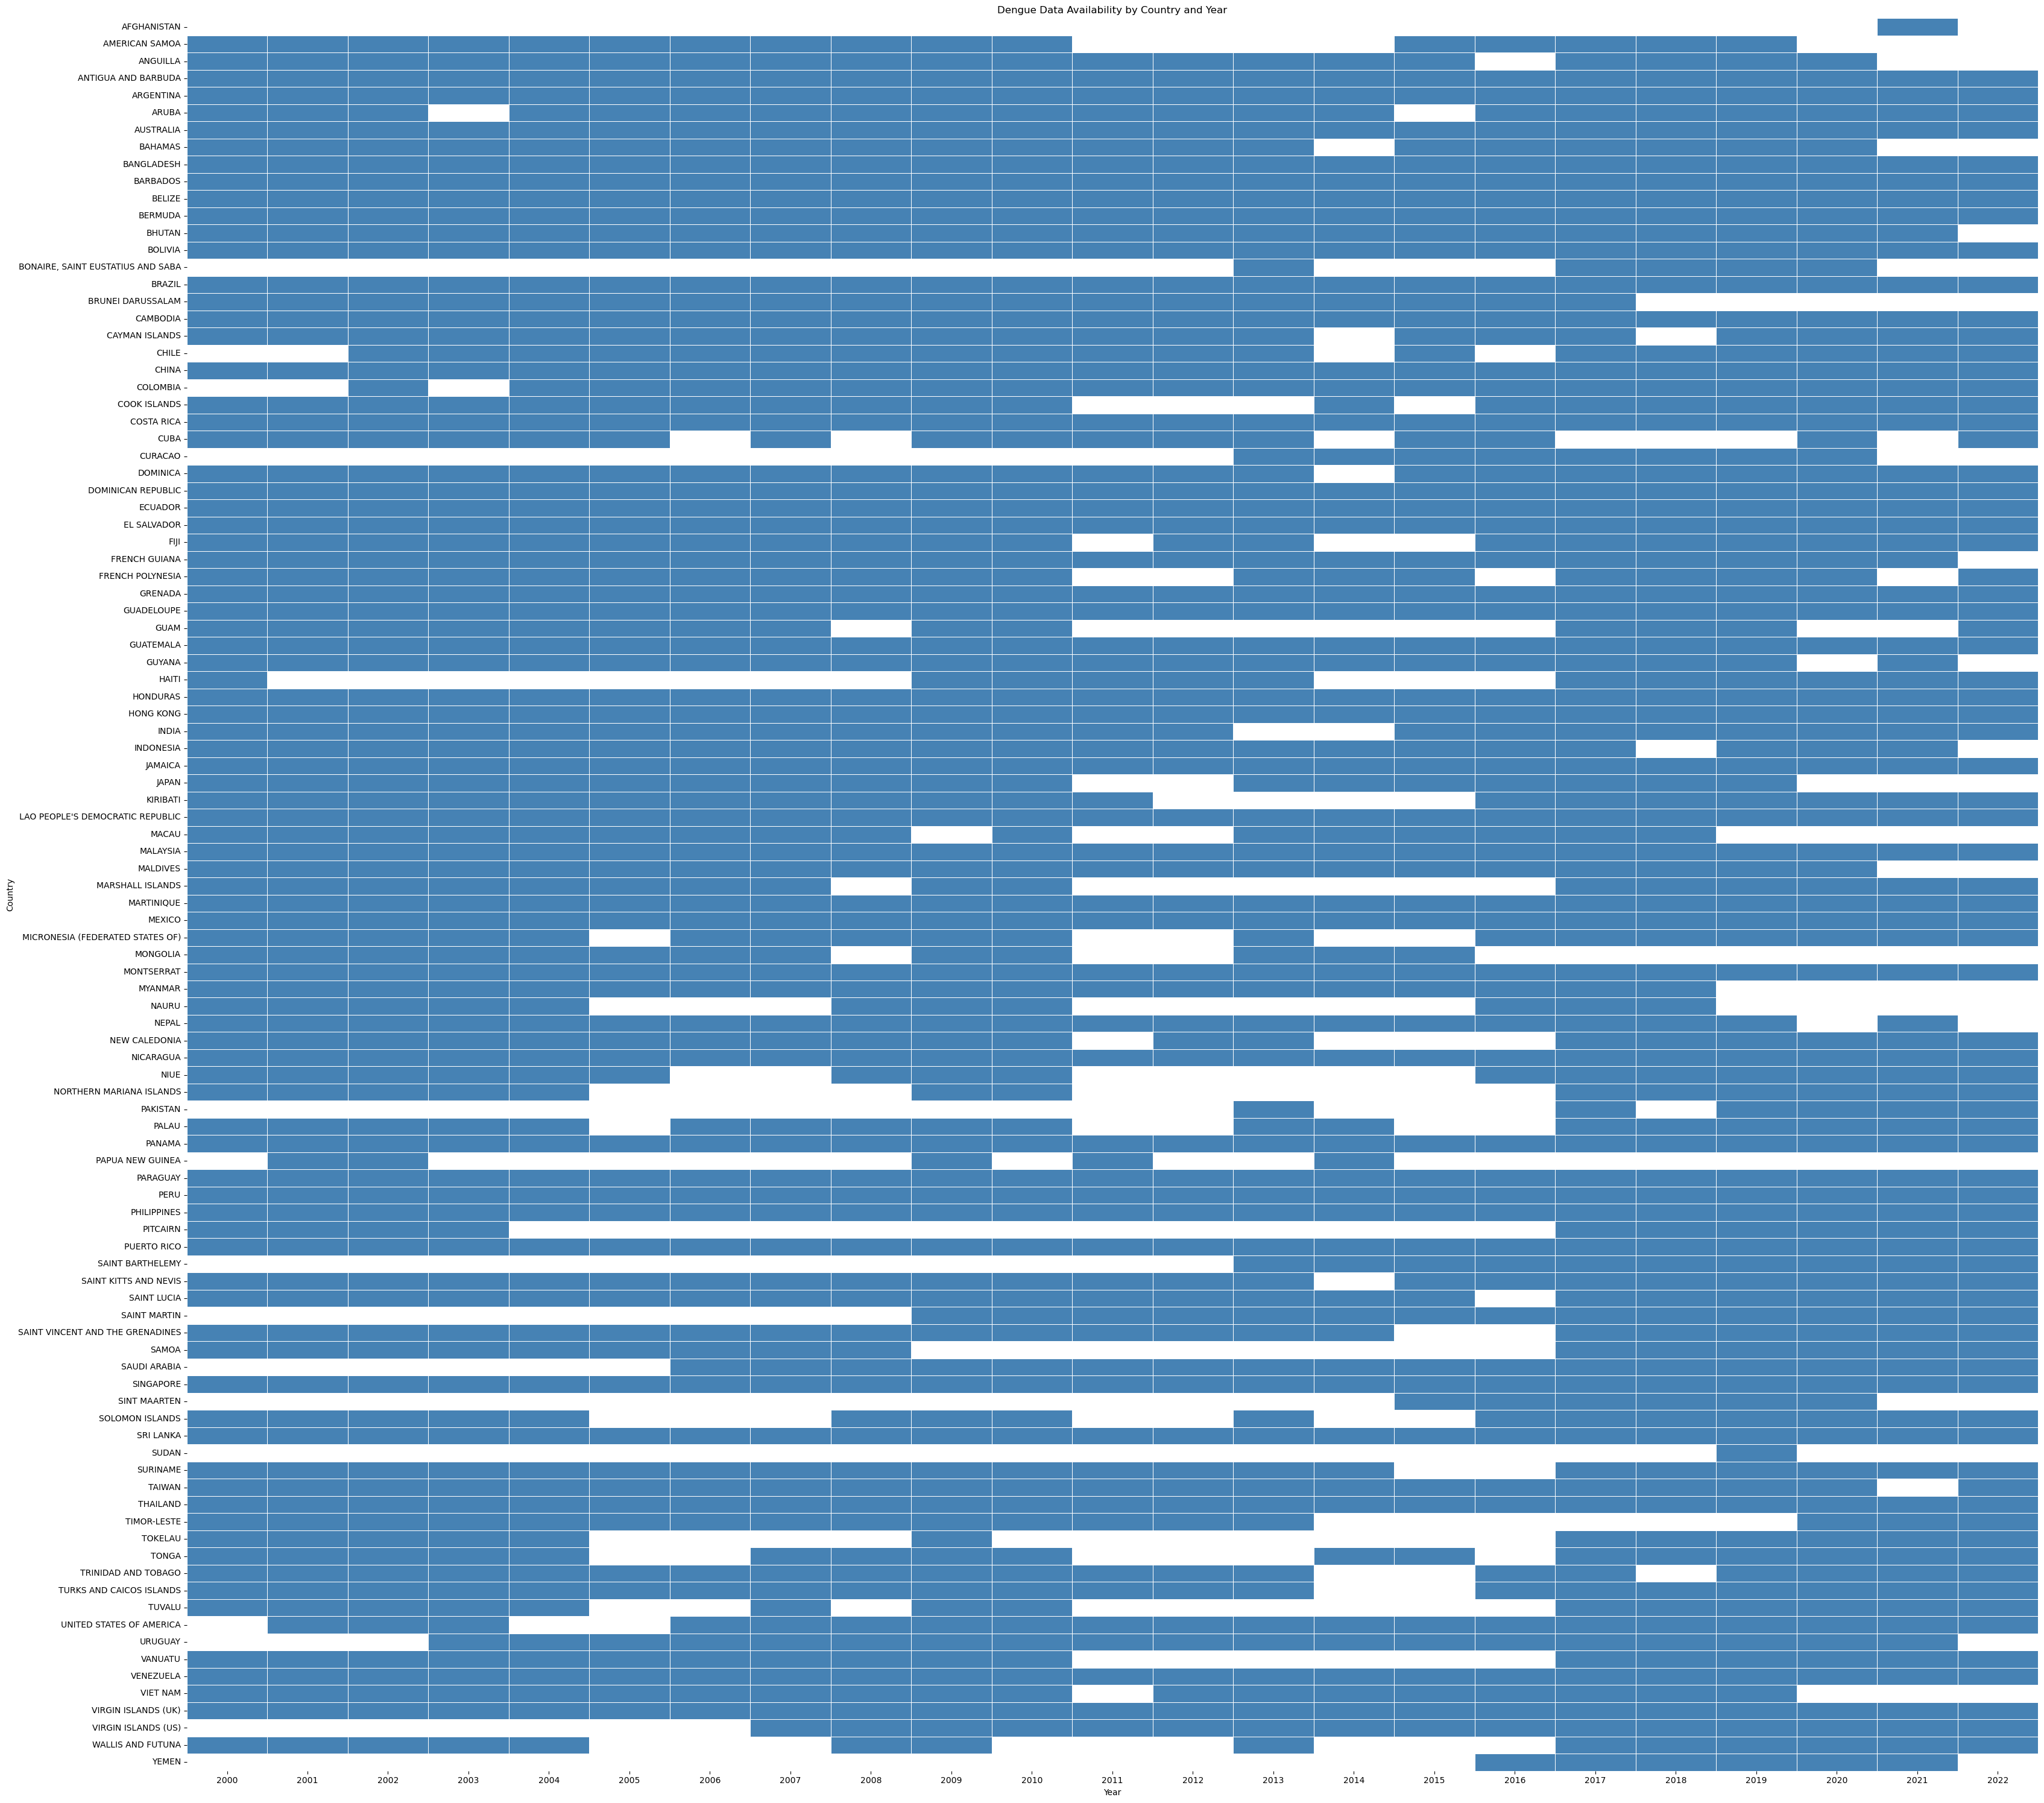

In [10]:
# Check data availability
# When a country has multiple rows per year, count it as "data exists"
availability = pd.pivot_table(
    dengue_sub,
    index='full_name',  # Country column
    columns='Year',     # Year column
    values='dengue_total',  # Case count column
    aggfunc='count'     # Count occurrences
)

# Convert to binary (data exists or not)
availability = availability.notna().astype(int)

# Create a heatmap
plt.figure(figsize=(34, 30))
sns.heatmap(
    availability, 
    cmap=['white', 'steelblue'],  # White -> missing, blue -> available
    cbar=False,      # No colorbar
    linewidths=0.5   # grid lines
)

plt.title('Dengue Data Availability by Country and Year')
plt.xlabel('Year')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

In [11]:
# Filter countries with 17 or more years of data

# Count years with data for each country
years_count = availability.sum(axis=1)

#List of countries with 17 or more years of data
countries_with_sufficient_data = years_count[years_count >= 17].index.tolist()

#Filter to include only these countries
dengue_sub2 = dengue_sub[dengue_sub['full_name'].isin(countries_with_sufficient_data)]

# Optional: Print how many countries meet your criteria
print(f"Number of countries with 17+ years of data: {len(countries_with_sufficient_data)}")
# print("Countries included:")
# for country in sorted(countries_with_sufficient_data):
#     print(f"{country}")

Number of countries with 17+ years of data: 75


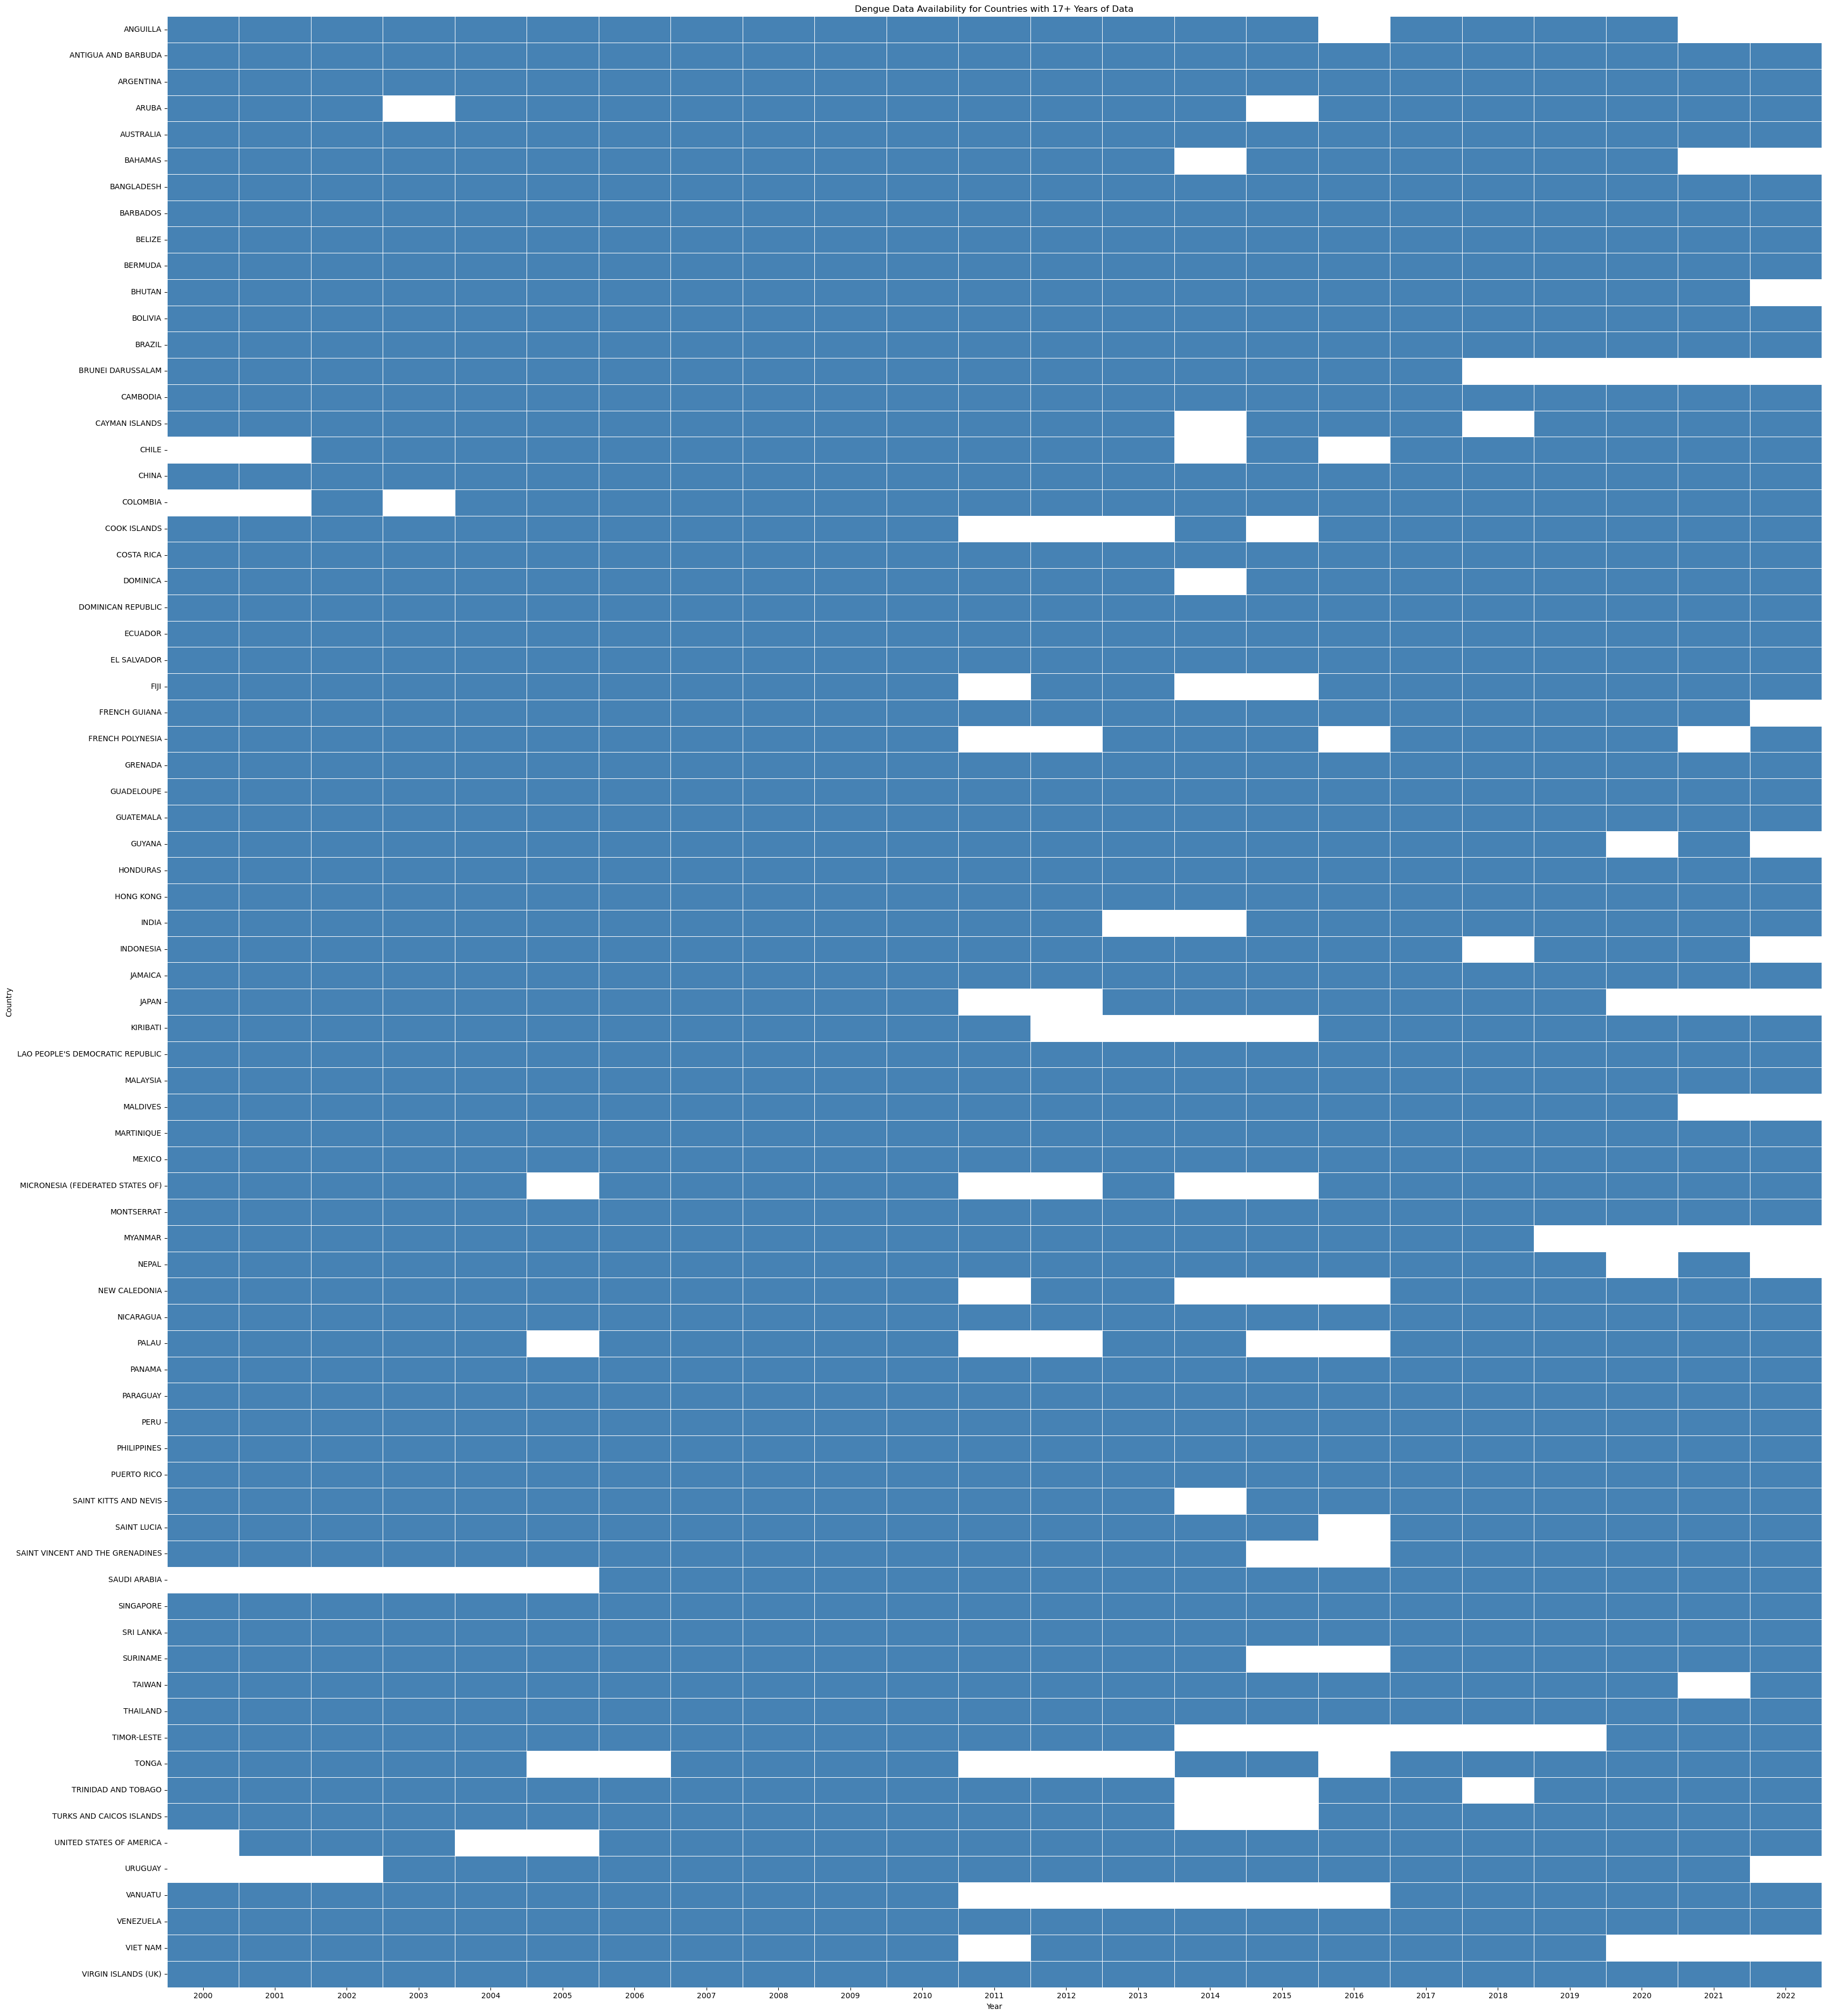

Original number of countries: 102
Number of countries with 17+ years of data: 75
Percentage of countries retained: 73.5%


In [12]:
# Heat map after filtering

#filtered version of your availability matrix
filtered_availability = availability.loc[countries_with_sufficient_data]

# heatmap
plt.figure(figsize=(34, len(countries_with_sufficient_data) * 0.5))
sns.heatmap(
    filtered_availability,
    cmap=['white', 'steelblue'],  # White -> missing, blue -> available
    cbar=False,                   # No colorbar
    linewidths=0.5                # grid lines
)
plt.title('Dengue Data Availability for Countries with 17+ Years of Data')
plt.xlabel('Year')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

# filtering stats
print(f"Original number of countries: {len(availability)}")
print(f"Number of countries with 17+ years of data: {len(countries_with_sufficient_data)}")
print(f"Percentage of countries retained: {len(countries_with_sufficient_data)/len(availability)*100:.1f}%")

In [13]:
# Aggregate by country and year, summing the case counts
yearly_case_counts = dengue_sub2.groupby(['full_name', 'Year'])['dengue_total'].sum().reset_index()

# Take a look at the result
print(yearly_case_counts.head())


#Create a pivot table
case_pivot = yearly_case_counts.pivot(index='full_name', columns='Year', values='dengue_total')
print(case_pivot.head())


  full_name  Year  dengue_total
0  ANGUILLA  2000           3.0
1  ANGUILLA  2001          25.0
2  ANGUILLA  2002           5.0
3  ANGUILLA  2003           2.0
4  ANGUILLA  2004           0.0
Year                   2000   2001   2002   2003    2004   2005   2006   2007  \
full_name                                                                       
ANGUILLA                3.0   25.0    5.0    2.0     0.0    0.0    0.0    0.0   
ANTIGUA AND BARBUDA     8.0   20.0    5.0    1.0     0.0    0.0    0.0    0.0   
ARGENTINA            1700.0   11.0  234.0  135.0  3284.0  249.0  181.0  173.0   
ARUBA                  76.0    0.0   25.0    NaN   173.0    0.0    5.0    0.0   
AUSTRALIA             217.0  183.0  224.0  868.0   356.0  219.0  188.0  316.0   

Year                  2008     2009  ...    2013    2014    2015     2016  \
full_name                            ...                                    
ANGUILLA               9.0      0.0  ...     8.0     2.0     0.0      NaN   
ANTIGUA A

<h1><center>Population Data</center></h1>

In [14]:
# Peek at the data
urban_pop

,Index,"Region, subregion, country or area",Note,Country\ncode,1950,1951,1952,1953,1954,1955,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
0,13,AFRICA,NaN,903,32658.962,34209.713,35856.699,37604.048,39457.151,41419.217,...,1158893.094,1193268.358,1228241.613,1263807.666,1299953.249,1336663.829,1373927.679,1411732.868,1450067.812,1488920.045
1,14,Eastern Africa,NaN,910,3836.643,4035.833,4248.289,4476.695,4719.781,4978.234,...,308912.691,320072.229,331473.026,343125.930,355029.937,367181.366,379578.018,392217.721,405098.197,418216.589
2,15,Burundi,NaN,108,39.974,41.594,43.158,44.716,46.320,48.001,...,4770.827,5001.763,5241.848,5491.101,5749.545,6017.295,6294.464,6581.084,6877.155,7182.692
3,16,Comoros,NaN,174,10.526,11.504,12.542,13.645,14.827,16.095,...,475.180,488.229,501.474,514.902,528.510,542.292,556.242,570.355,584.625,599.041
4,17,Djibouti,NaN,262,24.682,25.851,27.111,28.437,29.835,31.323,...,1029.403,1039.155,1048.634,1057.841,1066.788,1075.467,1083.873,1092.010,1099.862,1107.450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,269,Samoa,NaN,882,10.579,11.569,12.642,13.799,15.049,16.398,...,43.630,44.552,45.523,46.497,47.472,48.447,49.422,50.399,51.377,52.365
257,270,Tokelau,NaN,772,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
258,271,Tonga,NaN,776,6.084,6.595,7.101,7.599,8.085,8.566,...,35.140,35.848,36.577,37.305,38.030,38.756,39.480,40.201,40.925,41.654
259,272,Tuvalu,NaN,798,0.578,0.606,0.636,0.669,0.706,0.745,...,10.352,10.458,10.565,10.672,10.771,10.882,10.988,11.096,11.203,11.310


In [15]:
# Country names
id_column = 'Region, subregion, country or area'

# Select year columns from 2000-2022 (Int)
year_columns = [year for year in range(2000, 2023)]

# Select country and year columns
urban_pop1 = urban_pop[[id_column] + year_columns]

urban_pop1.head()


,"Region, subregion, country or area",2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,AFRICA,285997.612,296129.294,306701.760,317674.047,329075.105,341033.592,353403.533,365856.972,379488.153,...,456734.381,473878.136,491531.092,509683.886,528371.323,547602.182,567387.619,587737.793,608654.401,630139.701
1,Eastern Africa,54950.508,57288.639,59739.587,62252.620,64874.159,67684.204,70638.244,73364.499,76912.459,...,96959.877,101429.642,106095.604,110963.377,116034.318,121315.521,126809.813,132520.364,138450.877,144606.311
2,Burundi,527.819,554.716,585.300,619.362,656.406,695.940,738.134,783.189,830.899,...,1102.259,1164.881,1231.911,1303.761,1380.418,1461.704,1547.197,1636.586,1729.900,1827.394
3,Comoros,152.293,155.847,159.406,162.993,166.647,170.493,174.541,178.798,183.275,...,209.271,215.196,221.334,227.690,234.273,241.092,248.160,255.487,263.083,270.954
4,Djibouti,549.178,561.093,571.782,581.627,591.287,601.236,611.545,622.049,632.825,...,692.437,705.235,717.972,730.569,743.079,755.533,768.001,780.538,793.138,805.774


In [16]:
# Check for missing values
urban_pop1.isnull().sum()

Region, subregion, country or area    0
2000                                  0
2001                                  0
2002                                  0
2003                                  0
2004                                  0
2005                                  0
2006                                  0
2007                                  0
2008                                  0
2009                                  0
2010                                  0
2011                                  0
2012                                  0
2013                                  0
2014                                  0
2015                                  0
2016                                  0
2017                                  0
2018                                  0
2019                                  0
2020                                  0
2021                                  0
2022                                  0
dtype: int64

In [17]:
# Fuzzy matching function using library thefuzz
def match_country(country_name, country_list, threshold=85):
    match, score = process.extractOne(
        country_name, 
        country_list,
        scorer=fuzz.token_set_ratio  #algorithm
    )
    if score >= threshold:
        return match
    return None

# Mapping dictionary from urban_pop countries to dengue countries
country_mapping = {}
for country in case_pivot.index.tolist():
    match = match_country(country, urban_pop1[id_column].tolist())
    if match:
        country_mapping[country] = match

# Issue with 'AUSTRALIA': 'Australia/New Zealand', manual fix
country_mapping['AUSTRALIA'] = 'Australia'

In [18]:
country_mapping

{'ANGUILLA': 'Anguilla',
 'ANTIGUA AND BARBUDA': 'Antigua and Barbuda',
 'ARGENTINA': 'Argentina',
 'ARUBA': 'Aruba',
 'AUSTRALIA': 'Australia',
 'BAHAMAS': 'Bahamas',
 'BANGLADESH': 'Bangladesh',
 'BARBADOS': 'Barbados',
 'BELIZE': 'Belize',
 'BERMUDA': 'Bermuda',
 'BHUTAN': 'Bhutan',
 'BOLIVIA': 'Bolivia (Plurinational State of)',
 'BRAZIL': 'Brazil',
 'BRUNEI DARUSSALAM': 'Brunei Darussalam',
 'CAMBODIA': 'Cambodia',
 'CAYMAN ISLANDS': 'Cayman Islands',
 'CHILE': 'Chile',
 'CHINA': 'China',
 'COLOMBIA': 'Colombia',
 'COOK ISLANDS': 'Cook Islands',
 'COSTA RICA': 'Costa Rica',
 'DOMINICA': 'Dominica',
 'DOMINICAN REPUBLIC': 'Dominican Republic',
 'ECUADOR': 'Ecuador',
 'EL SALVADOR': 'El Salvador',
 'FIJI': 'Fiji',
 'FRENCH GUIANA': 'French Guiana',
 'FRENCH POLYNESIA': 'Polynesia',
 'GRENADA': 'Grenada',
 'GUADELOUPE': 'Guadeloupe',
 'GUATEMALA': 'Guatemala',
 'GUYANA': 'Guyana',
 'HONDURAS': 'Honduras',
 'HONG KONG': 'China, Hong Kong SAR',
 'INDIA': 'India',
 'INDONESIA': 'Indones

In [19]:
# filter uraban_pop1 based on value in dictionary from country_mapping, make a copy
urban_pop2 = urban_pop1[urban_pop1[id_column].isin(country_mapping.values())].copy()

# Invert country_mapping for renaming
inverted_mapping = {v: k for k, v in country_mapping.items()}

# Rename the countries in urban_pop2 to match those in case_pivot
urban_pop2[id_column] = urban_pop2[id_column].map(inverted_mapping)

# Reset index with id_column and drop
urban_pop2 = urban_pop2.set_index(id_column, drop=True)

In [20]:
urban_pop2

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
"Region, subregion, country or area",,,,,,,,,,,,,,,,,,,,,
CHINA,460377.048,478841.638,499010.479,519610.280,540635.912,561983.323,583095.080,604219.506,625674.528,647369.562,...,733059.486,754262.825,775352.918,796289.491,816957.613,837022.095,856409.297,875075.919,892977.294,910080.750
HONG KONG,6663.654,6722.306,6759.491,6782.571,6802.597,6827.761,6860.376,6898.397,6940.323,6983.272,...,7148.571,7194.563,7245.701,7302.843,7364.883,7428.887,7490.776,7547.652,7598.189,7643.256
TAIWAN,15258.841,15450.818,15675.104,15903.372,16127.259,16339.969,16539.954,16728.862,16908.831,17082.950,...,17749.773,17908.347,18064.348,18218.159,18369.720,18518.291,18662.774,18802.314,18936.553,19065.559
JAPAN,100303.716,102165.938,104428.752,106547.065,108520.519,110340.709,111887.819,113271.669,114542.316,115696.464,...,117055.095,117017.577,116944.428,116835.097,116693.276,116521.525,116322.813,116099.672,115853.245,115583.843
BANGLADESH,31040.651,32314.063,33817.103,35350.710,36901.153,38452.976,40001.295,41547.154,43106.528,44698.643,...,51624.214,53455.788,55305.132,57168.030,59046.818,60944.245,62865.820,64814.953,66791.896,68791.790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KIRIBATI,36.259,37.325,37.988,38.680,39.415,40.209,41.503,43.211,44.993,46.811,...,54.188,56.083,58.024,60.000,61.996,64.011,66.036,68.069,70.100,72.129
PALAU,13.487,13.601,13.672,13.711,13.939,14.163,14.391,14.615,14.845,15.075,...,16.079,16.351,16.638,16.939,17.245,17.556,17.869,18.175,18.482,18.790
FRENCH POLYNESIA,261.653,265.273,268.338,272.052,276.035,279.580,282.636,285.205,287.471,289.678,...,298.426,299.814,301.388,303.192,305.232,307.400,309.572,311.603,313.427,315.125


<h1><center>Merged Data</center></h1>

In [21]:
# merge the data
merged_data = case_pivot.join(urban_pop2, how='inner', lsuffix='_cases', rsuffix='_pop')

In [22]:
merged_data

,2000_cases,2001_cases,2002_cases,2003_cases,2004_cases,2005_cases,2006_cases,2007_cases,2008_cases,2009_cases,...,2013_pop,2014_pop,2015_pop,2016_pop,2017_pop,2018_pop,2019_pop,2020_pop,2021_pop,2022_pop
ANGUILLA,3.0,25.0,5.0,2.0,0.0,0.0,0.0,0.0,9.0,0.0,...,14.299,14.459,14.611,14.764,14.909,15.045,15.174,15.283,15.380,15.456
ANTIGUA AND BARBUDA,8.0,20.0,5.0,1.0,0.0,0.0,0.0,0.0,17.0,0.0,...,24.798,24.891,24.981,25.085,25.210,25.350,25.507,25.682,25.873,26.086
ARGENTINA,1700.0,11.0,234.0,135.0,3284.0,249.0,181.0,173.0,40.0,26612.0,...,38817.436,39275.143,39728.358,40175.981,40618.237,41055.867,41489.566,41919.857,42346.437,42768.727
ARUBA,76.0,0.0,25.0,NaN,173.0,0.0,5.0,0.0,0.0,845.0,...,44.361,44.674,44.979,45.275,45.572,45.872,46.182,46.511,46.848,47.200
AUSTRALIA,217.0,183.0,224.0,868.0,356.0,219.0,188.0,316.0,557.0,1404.0,...,19794.324,20094.765,20396.531,20700.043,21003.923,21307.040,21607.414,21903.705,22195.539,22483.604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
URUGUAY,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3232.264,3246.699,3261.533,3276.757,3292.209,3307.662,3322.873,3337.671,3351.956,3365.738
VANUATU,0.0,20.0,15.0,122.0,26.0,2.0,168.0,82.0,96.0,45.0,...,62.679,64.352,66.048,67.768,69.511,71.301,73.139,75.025,76.962,78.950
VENEZUELA,21130.0,83180.0,37676.0,26996.0,30693.0,42198.0,39860.0,80646.0,48048.0,65869.0,...,26720.130,27094.003,27464.635,27832.085,28198.251,28562.719,28924.869,29284.219,29640.551,29993.895
VIET NAM,25269.0,42878.0,31760.0,49751.0,78692.0,57080.0,68792.0,104553.0,96451.0,105370.0,...,29672.223,30646.691,31635.369,32635.787,33642.498,34658.961,35686.730,36727.248,37779.862,38841.525


In [ ]:
# merged to cvs
# merged_data.to_csv('merged_data.csv')

<h1><center>Analysis</center></h1>

In [ ]:
# Load the data
df = pd.read_csv('merged_data.csv')
df.columns = df.columns.str.strip()

# Set the first column as index
country_col = df.columns[0]
df = df.set_index(country_col)

# Extract case columns and population columns
case_cols = [col for col in df.columns if 'cases' in col]
pop_cols = [col for col in df.columns if 'pop' in col]
years = [int(col.split('_')[0]) for col in case_cols]

In [ ]:
# Function to analyze trend for a single country
def analyze_country_trend(country_name):
    country_data = df.loc[country_name, case_cols].values
    valid_data = ~np.isnan(country_data)
    
    # All countries have at least 17 data points for cases
    valid_years = np.array(years)[valid_data]
    valid_cases = country_data[valid_data]
    
    # Linear regression to test for significant trend
    X = valid_years.reshape(-1, 1) # Reshape 1D array into a 2D array
    X_with_const = sm.add_constant(X) # Add constant for intercept
    
    try:
        model = sm.OLS(valid_cases, X_with_const).fit()
        p_value = model.pvalues[1]  # p-value for the slope coefficient
        slope = model.params[1]     # slope coefficient
        
        return {
            'Country': country_name,
            'Trend_Significant': p_value < 0.05,
            'P_value': p_value,
            'Slope': slope,
            'Direction': 'Increasing' if slope > 0 else 'Decreasing',
            'Data_Points': len(valid_years)
        }
    except:
        return None


In [28]:
# Analyze trends for each country
trend_results = []
for country in df.index:
    result = analyze_country_trend(country)
    if result is not None:
        trend_results.append(result)

trend_df = pd.DataFrame(trend_results)

In [30]:
trend_df.head()

,Country,Trend_Significant,P_value,Slope,Direction,Data_Points
0,ANGUILLA,False,0.317940,-0.231358,Decreasing,20
1,ANTIGUA AND BARBUDA,False,0.169930,3.202569,Increasing,23
2,ARGENTINA,False,0.138589,936.030632,Increasing,23
3,ARUBA,False,0.824764,-5.426877,Decreasing,21
4,AUSTRALIA,False,0.082200,36.218379,Increasing,23


In [ ]:
# Display summary statistics
significant_trends = trend_df[trend_df['Trend_Significant']]
print(f"Total countries analyzed: {len(trend_df)}")
print(f"Countries with significant trends: {len(significant_trends)} ({len(significant_trends)*100/len(trend_df):.1f}%)")
increasing = significant_trends[significant_trends['Slope'] > 0]
decreasing = significant_trends[significant_trends['Slope'] < 0]
print(f"Significant increasing trends: {len(increasing)} ({len(increasing)*100/len(significant_trends):.1f}% of significant)")
print(f"Significant decreasing trends: {len(decreasing)} ({len(decreasing)*100/len(significant_trends):.1f}% of significant)")

# Display top countries with increasing/decreasing trends
print("\nTop 5 countries with strongest increasing trends:")
print(increasing.sort_values('Slope', ascending=False).head(5)[['Country', 'Slope', 'P_value']])

print("\nTop countries with strongest decreasing trends:")
print(decreasing.sort_values('Slope').head(10)[['Country', 'Slope', 'P_value']])

Total countries analyzed: 75
Countries with significant trends: 22 (29.3%)
Significant increasing trends: 19 (86.4% of significant)
Significant decreasing trends: 3 (13.6% of significant)

Top 10 countries with strongest increasing trends:
        Country         Slope   P_value
12       BRAZIL  67772.369565  0.000322
54  PHILIPPINES  19060.111660  0.003383
73     VIET NAM  16776.056235  0.000135
34        INDIA   8990.727498  0.000002
40     MALAYSIA   6797.564229  0.003479
43       MEXICO   6195.862648  0.015115
49    NICARAGUA   4619.617589  0.000090
18     COLOMBIA   3693.119498  0.031664
61    SRI LANKA   3154.995059  0.004922
53         PERU   2190.051383  0.000212

Top countries with strongest decreasing trends:
                Country        Slope   P_value
72            VENEZUELA -1896.183794  0.045684
67  TRINIDAD AND TOBAGO  -128.545357  0.008300
62             SURINAME   -43.246381  0.036901


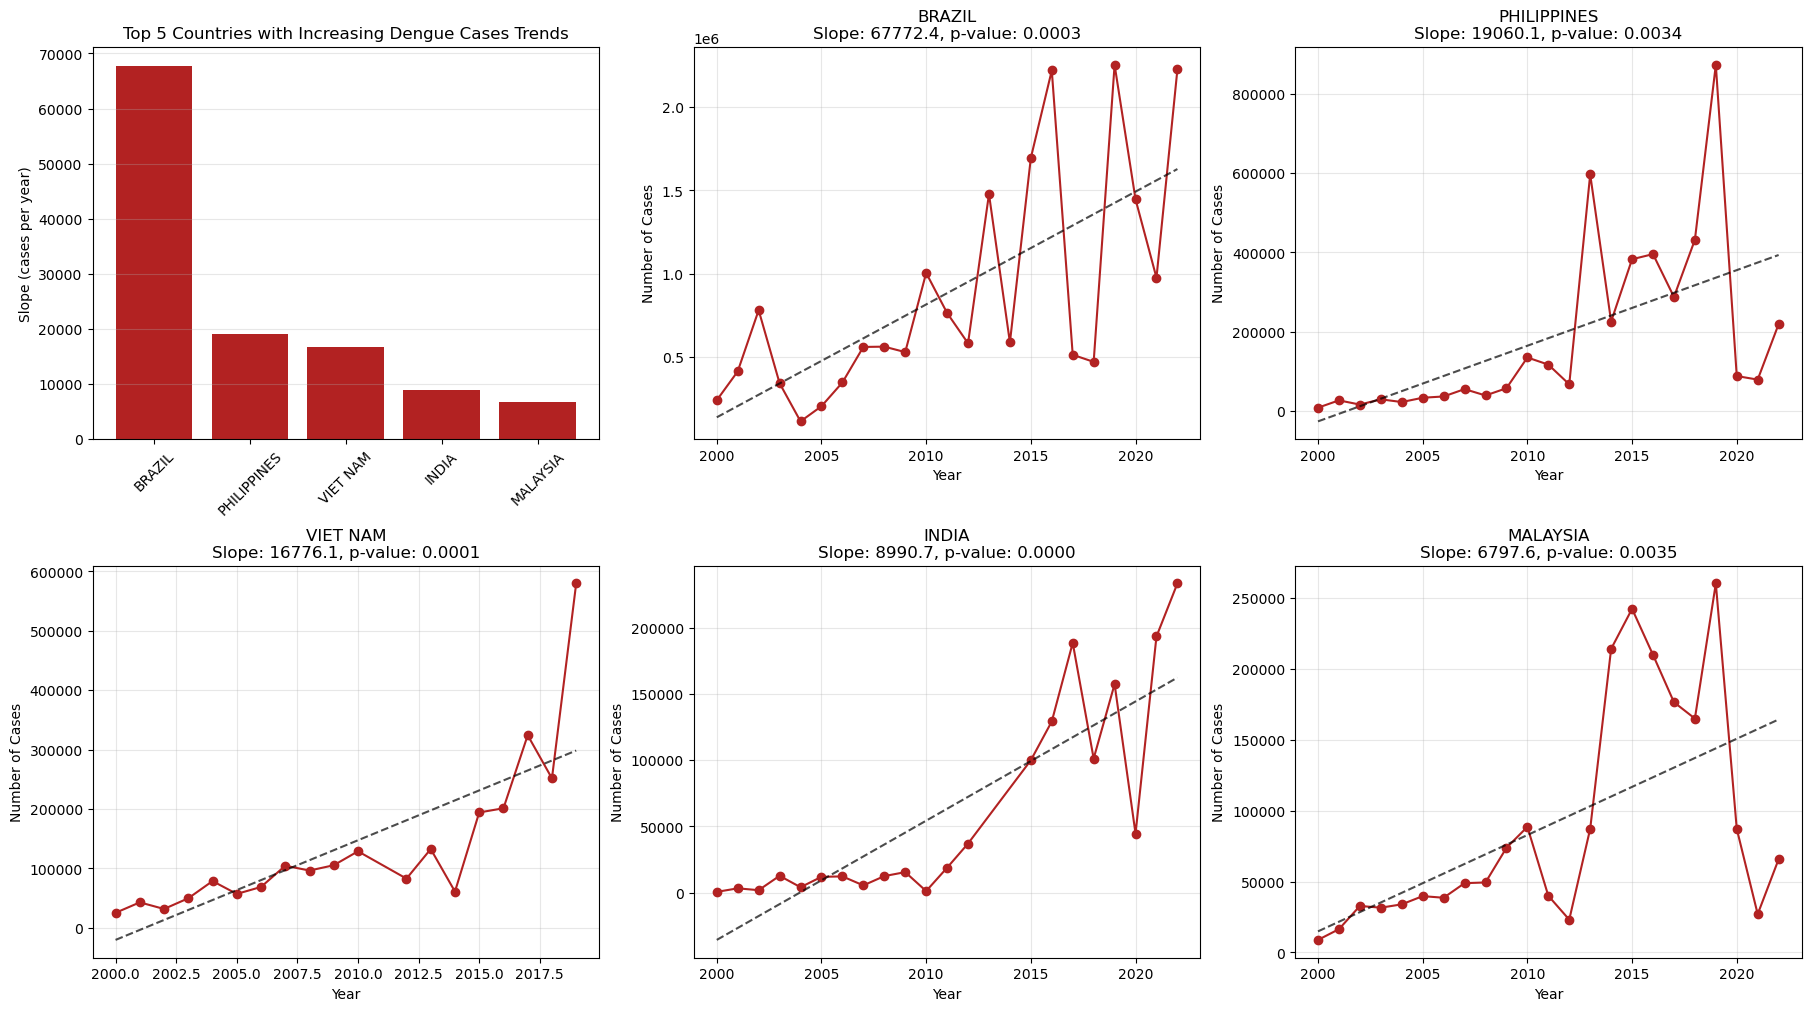

In [ ]:
def create_increasing_trends_visualization(trend_df, df, case_cols, years):
    # Get top countries with increasing trends (most significant or steepest slope)
    increasing = trend_df[(trend_df['Trend_Significant']) & (trend_df['Slope'] > 0)]
    top_increasing = increasing.sort_values('Slope', ascending=False).head(5)
    
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10), constrained_layout=True)
    axes = axes.flatten()
    
    # Create a summary bar chart in the first subplot
    countries = top_increasing['Country'].values
    slopes = top_increasing['Slope'].values
    
    # Bar chart of slopes
    axes[0].bar(countries, slopes, color='firebrick')
    axes[0].set_title('Top 5 Countries with Increasing Dengue Cases Trends')
    axes[0].set_ylabel('Slope (cases per year)')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Individual trend plots for each country
    for i, country in enumerate(countries, 1):
        country_data = df.loc[country, case_cols].values
        valid_data = ~np.isnan(country_data)
        
        valid_years = np.array(years)[valid_data]
        valid_cases = country_data[valid_data]
        
        # Plot the data
        axes[i].plot(valid_years, valid_cases, marker='o', linestyle='-', color='firebrick')
        
        # Add trend line
        X = valid_years.reshape(-1, 1)
        X_with_const = sm.add_constant(X)
        model = sm.OLS(valid_cases, X_with_const).fit()
        trend_y = model.predict(X_with_const)
        axes[i].plot(valid_years, trend_y, 'k--', alpha=0.7)
        
        # Annotate the plot
        slope = top_increasing.iloc[i-1]['Slope']
        p_value = top_increasing.iloc[i-1]['P_value']
        axes[i].set_title(f"{country}\nSlope: {slope:.1f}, p-value: {p_value:.4f}")
        axes[i].set_xlabel("Year")
        axes[i].set_ylabel("Number of Cases")
        axes[i].grid(True, alpha=0.3)
    
    # plt.savefig("top_increasing_dengue_trends.png", dpi=300, bbox_inches='tight')
    plt.show()
    
# function call
create_increasing_trends_visualization(trend_df, df, case_cols, years)

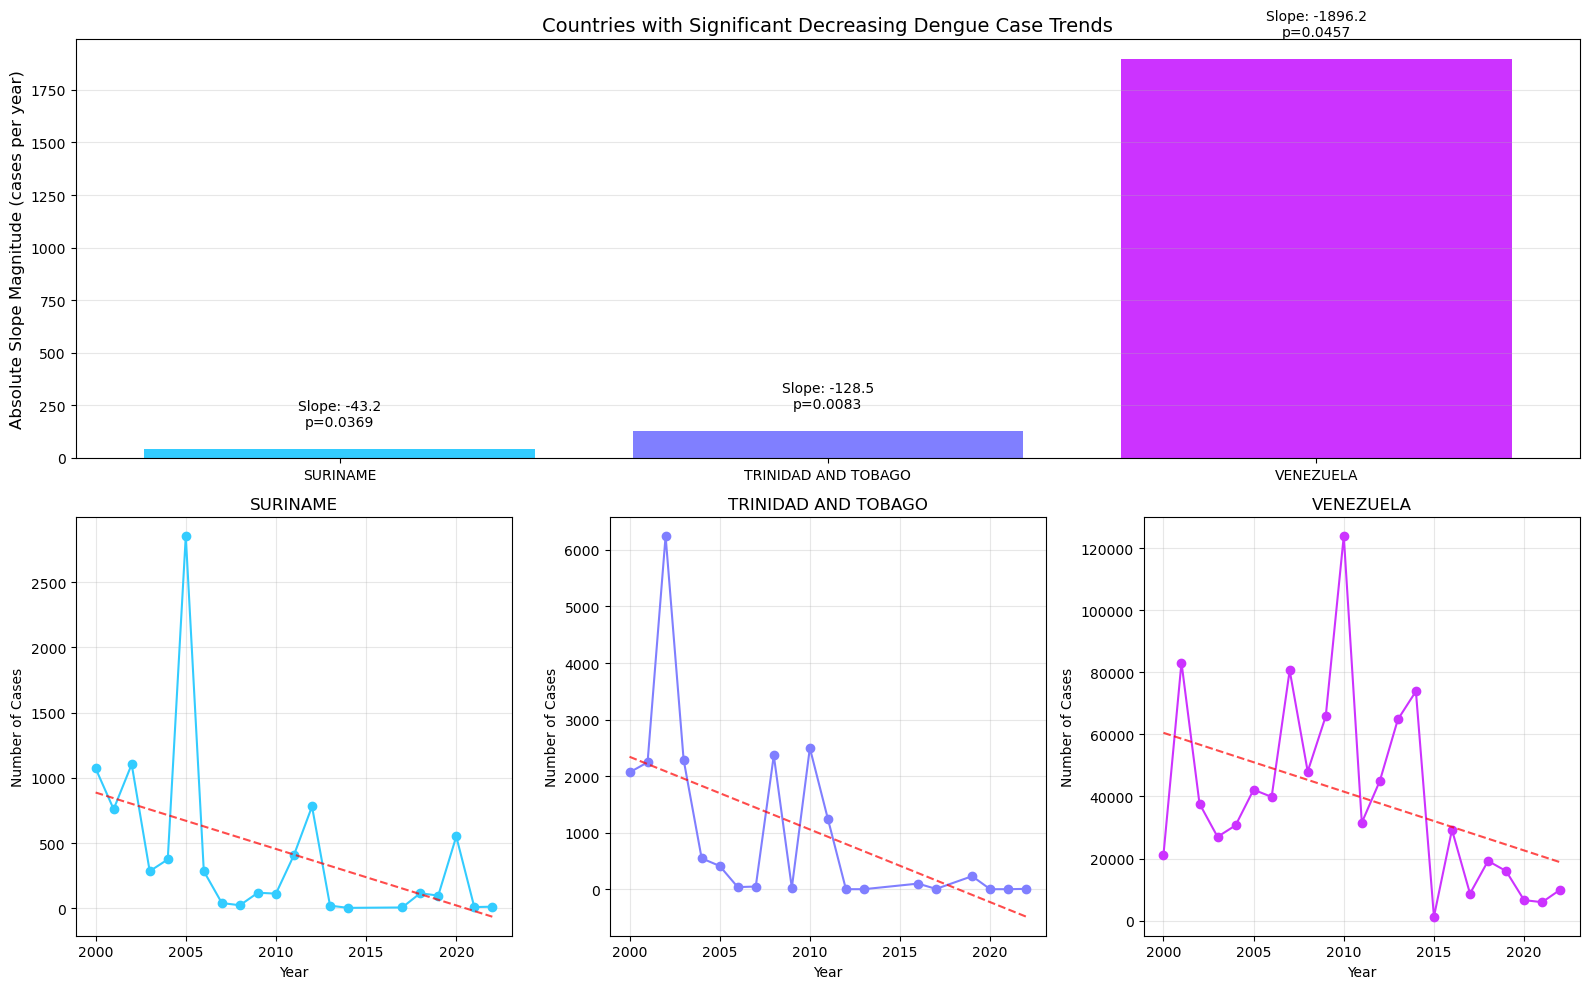

In [47]:
def visualize_decreasing_trends_modified(trend_df, df, case_cols, years):
    # Get all countries with significant decreasing trends
    decreasing = trend_df[(trend_df['Trend_Significant']) & (trend_df['Slope'] < 0)]
    
    # Extract the countries and their data
    countries = decreasing['Country'].values
    slopes = decreasing['Slope'].values
    p_values = decreasing['P_value'].values
    
    # Create a figure with subplots - one main comparison plot and one plot per country
    fig = plt.figure(figsize=(16, 10))
    
    # Define a grid layout - top row for summary, bottom row for individual trends
    gs = fig.add_gridspec(2, 3)
    
    # Top row for summary plot (spans whole width)
    ax_summary = fig.add_subplot(gs[0, :])
    
    # Create the summary bar chart
    bar_colors = plt.cm.cool(np.linspace(0.2, 0.8, len(countries)))
    bars = ax_summary.bar(countries, abs(slopes), color=bar_colors)
    
    # Add labels with actual slope values and p-values
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax_summary.text(bar.get_x() + bar.get_width()/2, height + max(abs(slopes))*0.05,
                f"Slope: {slopes[i]:.1f}\np={p_values[i]:.4f}", 
                ha='center', va='bottom', fontsize=10)
    
    ax_summary.set_title('Countries with Significant Decreasing Dengue Case Trends', fontsize=14)
    ax_summary.set_ylabel('Absolute Slope Magnitude (cases per year)', fontsize=12)
    ax_summary.grid(axis='y', alpha=0.3)
    
    # Bottom row for individual country trends
    for i, country in enumerate(countries):
        # Create subplot for each country
        ax_country = fig.add_subplot(gs[1, i])
        
        # Get country data
        country_data = df.loc[country, case_cols].values
        valid_data = ~np.isnan(country_data)
        
        valid_years = np.array(years)[valid_data]
        valid_cases = country_data[valid_data]
        
        # Plot the data
        ax_country.plot(valid_years, valid_cases, marker='o', linestyle='-', color=bar_colors[i])
        
        # Add trend line
        X = valid_years.reshape(-1, 1)
        X_with_const = sm.add_constant(X)
        model = sm.OLS(valid_cases, X_with_const).fit()
        trend_y = model.predict(X_with_const)
        ax_country.plot(valid_years, trend_y, 'r--', alpha=0.7)
        
        # Annotate the plot
        ax_country.set_title(f"{country}")
        ax_country.set_xlabel("Year")
        ax_country.set_ylabel("Number of Cases")
        ax_country.grid(True, alpha=0.3)
    
    plt.tight_layout()
    

# Call the function
visualize_decreasing_trends_modified(trend_df, df, case_cols, years)

In [ ]:
# Function to analyze population relationship for a single country
def analyze_pop_cases_relation(country_name):
    country_cases = df.loc[country_name, case_cols].values
    country_pop = df.loc[country_name, pop_cols].values
    
    valid_data = ~np.isnan(country_cases) & ~np.isnan(country_pop)
    
    valid_cases = country_cases[valid_data]
    valid_pop = country_pop[valid_data]
    
    try:
        correlation, p_value = pearsonr(valid_pop, valid_cases)
        
        return {
            'Country': country_name,
            'Correlation': correlation,
            'P_value': p_value,
            'Significant': p_value < 0.05,
            'Relationship': 'Positive' if correlation > 0 else 'Negative',
            'Data_Points': np.sum(valid_data)
        }
    except:
        return None

In [39]:
# Analyze population-cases relationship for each country
pop_case_results = []
for country in df.index:
    result = analyze_pop_cases_relation(country)
    if result is not None:
        pop_case_results.append(result)

pop_case_df = pd.DataFrame(pop_case_results)

In [50]:
# Display summary statistics
significant_assoc = pop_case_df[pop_case_df['Significant']]
print(f"Total countries analyzed: {len(pop_case_df)}")
print(f"Countries with significant population-cases association: {len(significant_assoc)} ({len(significant_assoc)*100/len(pop_case_df):.1f}%)")
positive = significant_assoc[significant_assoc['Correlation'] > 0]
negative = significant_assoc[significant_assoc['Correlation'] < 0]
print(f"Significant positive associations: {len(positive)} ({len(positive)*100/len(significant_assoc):.1f}%)")
print(f"Significant negative associations: {len(negative)} ({len(negative)*100/len(significant_assoc):.1f}%)")

# Display top countries with strongest associations
print("\nTop 10 countries with strongest positive association:")
print(positive.sort_values('Correlation', ascending=False).head(10)[['Country', 'Correlation', 'P_value']])

print("\nTop countries with strongest negative association:")
print(negative.sort_values('Correlation').head(10)[['Country', 'Correlation', 'P_value']])

Total countries analyzed: 75
Countries with significant population-cases association: 25 (33.3%)
Significant positive associations: 21 (84.0%)
Significant negative associations: 4 (16.0%)

Top 10 countries with strongest positive association:
        Country  Correlation   P_value
34        INDIA     0.847949  0.000001
65  TIMOR-LESTE     0.812068  0.000075
73     VIET NAM     0.791023  0.000055
49    NICARAGUA     0.726392  0.000087
37        JAPAN     0.715511  0.000842
53         PERU     0.698982  0.000207
25         FIJI     0.684137  0.000879
12       BRAZIL     0.677217  0.000386
51       PANAMA     0.616303  0.001739
40     MALAYSIA     0.594569  0.002771

Top countries with strongest negative association:
                Country  Correlation   P_value
45           MONTSERRAT    -0.747588  0.000041
31               GUYANA    -0.677309  0.000744
67  TRINIDAD AND TOBAGO    -0.550335  0.011927
62             SURINAME    -0.457688  0.036954


In [41]:
# Function to plot a country's dengue cases trend
def plot_country_trend(country_name):
    country_data = df.loc[country_name, case_cols].values
    valid_data = ~np.isnan(country_data)
    
    # No need to check for minimum data points
    valid_years = np.array(years)[valid_data]
    valid_cases = country_data[valid_data]
    
    plt.figure(figsize=(10, 6))
    plt.plot(valid_years, valid_cases, marker='o', linestyle='-')
    
    # Add trend line
    X = valid_years.reshape(-1, 1)
    X_with_const = sm.add_constant(X)
    model = sm.OLS(valid_cases, X_with_const).fit()
    trend_y = model.predict(X_with_const)
    plt.plot(valid_years, trend_y, 'r--', alpha=0.7)
    
    plt.title(f"Dengue Cases Trend for {country_name}")
    plt.xlabel("Year")
    plt.ylabel("Number of Cases")
    plt.grid(True, alpha=0.3)
    plt.savefig(f"{country_name}_trend.png")
    plt.close()

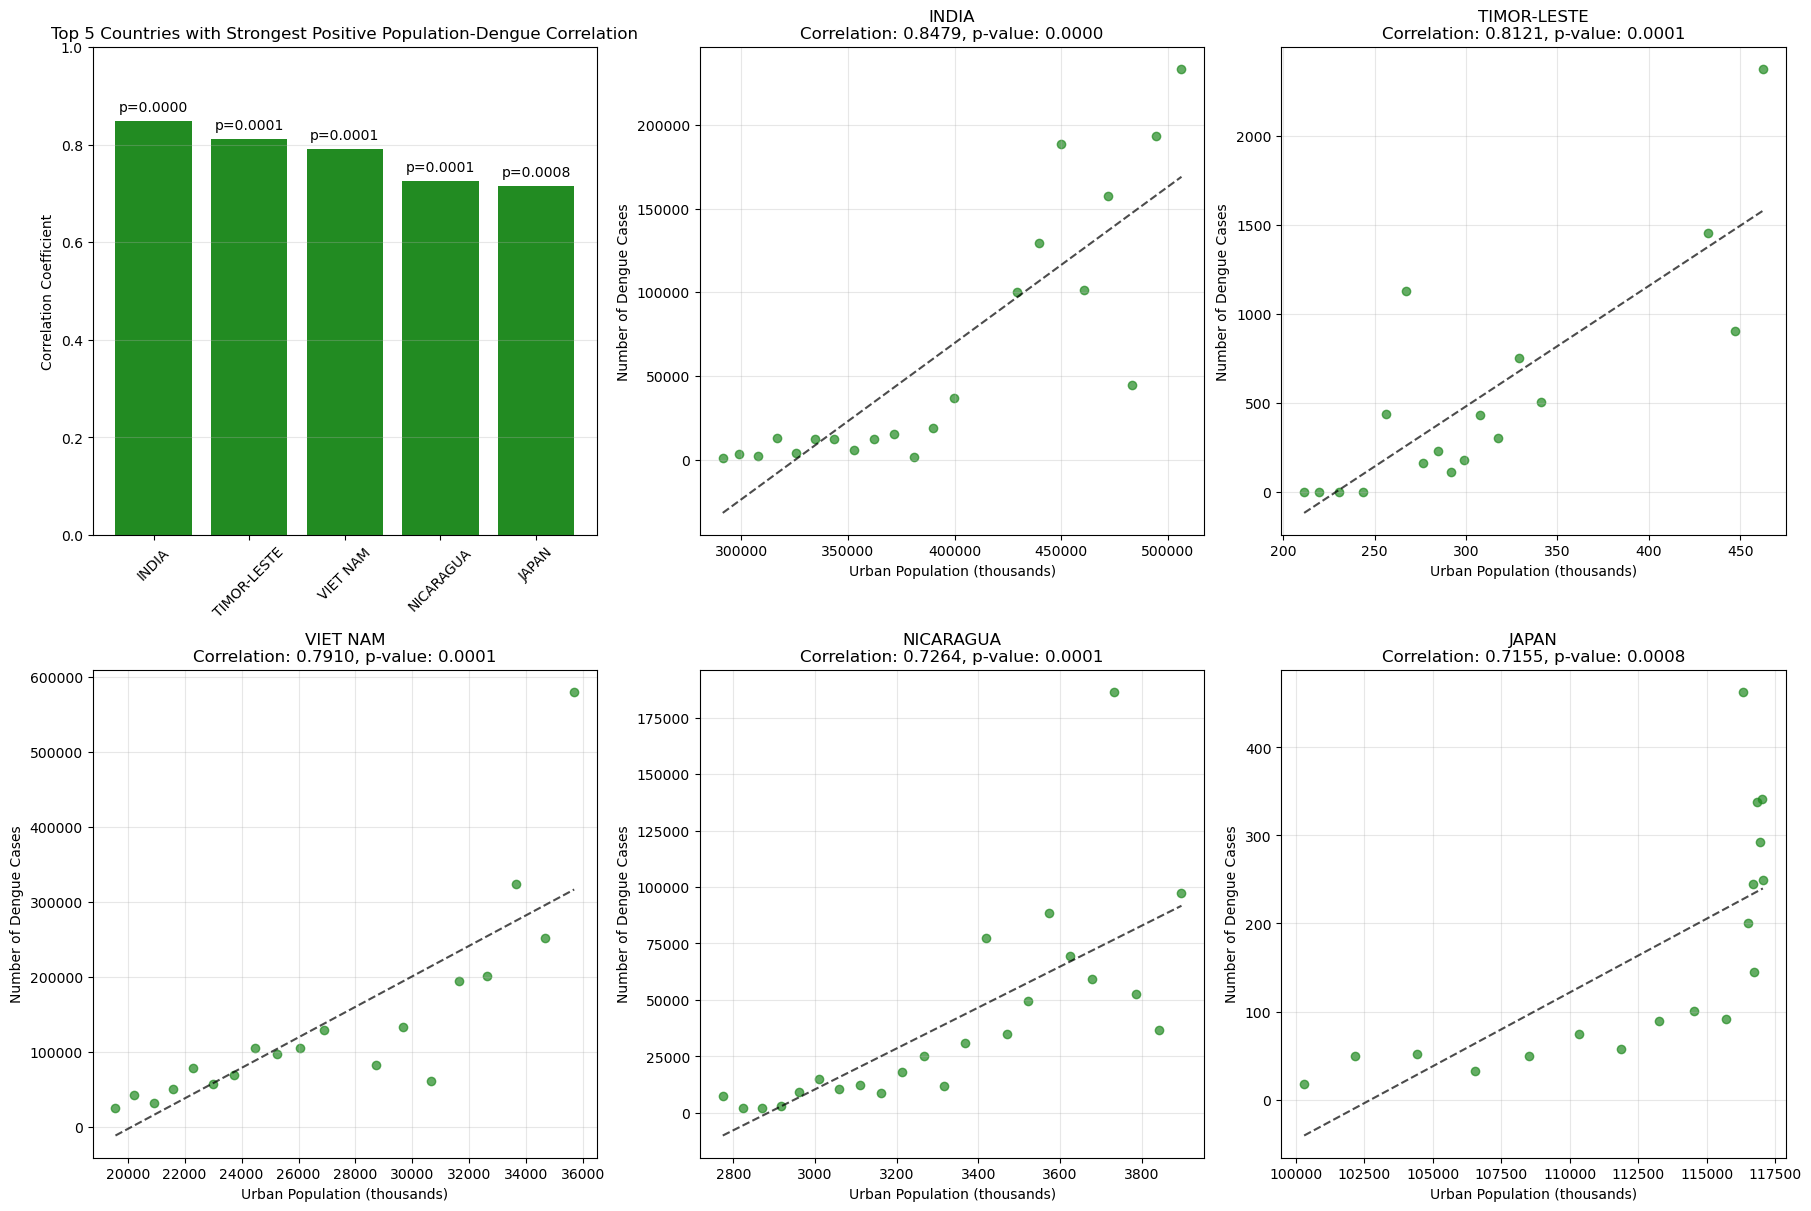

In [43]:
def visualize_strongest_positive_associations(pop_case_df, df, case_cols, pop_cols):
    # Get top 5 countries with strongest positive associations
    positive = pop_case_df[pop_case_df['Correlation'] > 0]
    top_positive = positive.sort_values('Correlation', ascending=False).head(5)
    
    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=(18, 12), constrained_layout=True)
    axes = axes.flatten()
    
    # Create summary bar chart in first subplot
    countries = top_positive['Country'].values
    correlations = top_positive['Correlation'].values
    
    # Bar chart of correlation values
    axes[0].bar(countries, correlations, color='forestgreen')
    axes[0].set_title('Top 5 Countries with Strongest Positive Population-Dengue Correlation')
    axes[0].set_ylabel('Correlation Coefficient')
    axes[0].set_ylim(0, 1)  # Correlation values range from 0 to 1 for positive correlations
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Add p-values as text
    for i, country in enumerate(countries):
        p_value = top_positive[top_positive['Country'] == country]['P_value'].values[0]
        axes[0].text(i, correlations[i] + 0.02, f"p={p_value:.4f}", ha='center')
    
    # Individual scatter plots for each country
    for i, country in enumerate(countries, 1):
        country_cases = df.loc[country, case_cols].values
        country_pop = df.loc[country, pop_cols].values
        
        valid_data = ~np.isnan(country_cases) & ~np.isnan(country_pop)
        valid_cases = country_cases[valid_data]
        valid_pop = country_pop[valid_data]
        
        # Plot the scatter points
        axes[i].scatter(valid_pop, valid_cases, color='forestgreen', alpha=0.7)
        
        # Add trend line
        X = valid_pop.reshape(-1, 1)
        X_with_const = sm.add_constant(X)
        model = sm.OLS(valid_cases, X_with_const).fit()
        pop_range = np.linspace(min(valid_pop), max(valid_pop), 100)
        X_pred = sm.add_constant(pop_range)
        trend_y = model.predict(X_pred)
        axes[i].plot(pop_range, trend_y, 'k--', alpha=0.7)
        
        # Add correlation statistics
        correlation = top_positive[top_positive['Country'] == country]['Correlation'].values[0]
        p_value = top_positive[top_positive['Country'] == country]['P_value'].values[0]
        axes[i].set_title(f"{country}\nCorrelation: {correlation:.4f}, p-value: {p_value:.4f}")
        axes[i].set_xlabel("Urban Population (thousands)")
        axes[i].set_ylabel("Number of Dengue Cases")
        axes[i].grid(True, alpha=0.3)
    
    plt.savefig("top_positive_population_dengue_associations.png", dpi=300, bbox_inches='tight')
    plt.show()
    
# Call the function with your existing variables
visualize_strongest_positive_associations(pop_case_df, df, case_cols, pop_cols)